In [1]:
# %matplotlib notebook

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
from scipy import signal
from scipy.signal import find_peaks
from scipy.integrate import cumtrapz
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# 変数の宣言
sampling_hz = 100

In [3]:
# csvファイルの読み込み
file = "up_down2_filter"
csv_Accelerometer = f'data/{file}/Accelerometer.csv'
csv_Gyroscope = f'data/{file}/Gyroscope.csv'
csv_Pressure = f'data/{file}/Pressure.csv'
raw_Accelerometer = pd.read_csv(csv_Accelerometer)
raw_Gyroscope = pd.read_csv(csv_Gyroscope)
raw_Pressure = pd.read_csv(csv_Pressure)

print(len(raw_Accelerometer))
print(len(raw_Gyroscope))
print(len(raw_Pressure))


6997
6995
387


<Figure size 640x480 with 0 Axes>

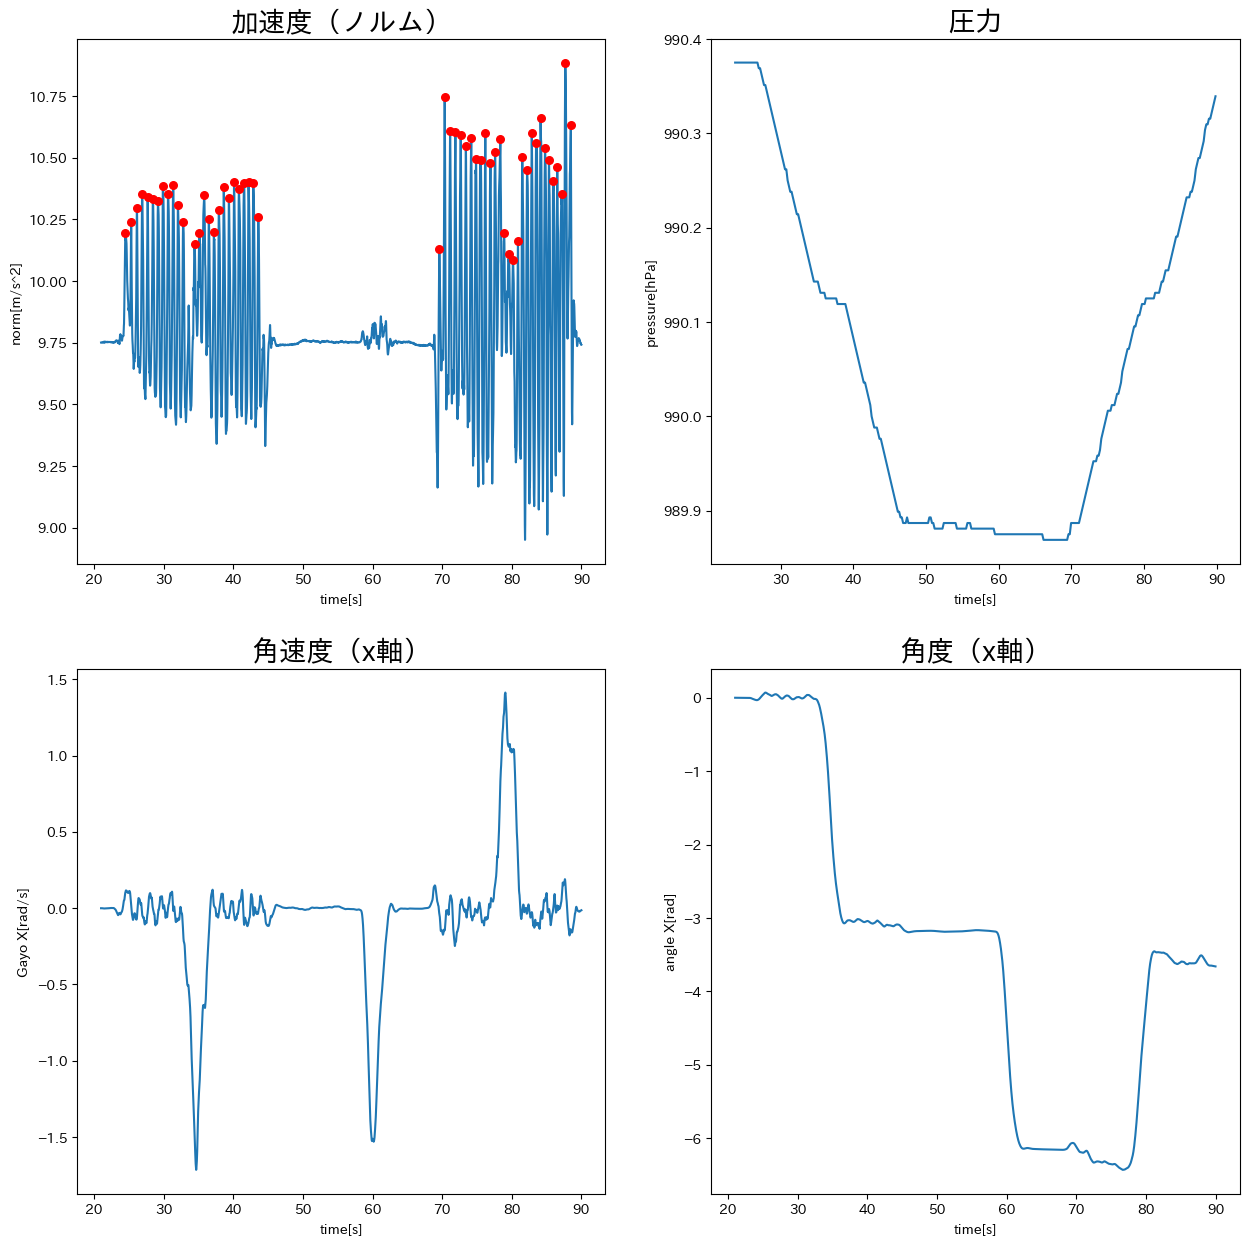

In [4]:
# 生データの描画
df_acc = pd.read_csv(csv_Accelerometer)
df_pre = pd.read_csv(csv_Pressure)
df_gyro = pd.read_csv(csv_Gyroscope)

df_acc['norm'] = (df_acc['x']**2 + df_acc['y']**2 + df_acc['z']**2)**(1/2)
df_gyro['norm'] = (df_gyro['x']**2 + df_gyro['y']**2 + df_gyro['z']**2)**(1/2)

df_gyro['angle'] = np.cumsum(df_gyro['x']) / sampling_hz

window_acc = 100
window_pre = 21
window_gayo = 100
df_acc['low_norm'] = df_acc['norm'].rolling(window= window_acc).mean()
df_pre['low'] = df_pre['p'].rolling(window= window_pre).mean()
df_gyro['low_x'] = df_gyro['x'].rolling(window= window_gayo).mean()
df_gyro['angle_x'] = df_gyro['angle'].rolling(window= window_gayo).mean()

plt.subplots_adjust(hspace=0.3)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(2,2,1)
ax1.plot(df_acc["t"], df_acc["low_norm"])
ax1.set_title("加速度（ノルム）", fontsize=20)
ax1.set_xlabel("time[s]")
ax1.set_ylabel("norm[m/s^2]")

peek, _ = signal.find_peaks(df_acc['low_norm'], distance=40 ,height=10)
ax1.scatter(df_acc['t'][peek], df_acc['low_norm']
            [peek], s=30, color='red', zorder=2)

ax2 = fig.add_subplot(2,2,2)
ax2.plot(df_pre["t"], df_pre["low"])
ax2.set_title("圧力", fontsize=20)
ax2.set_xlabel("time[s]")
ax2.set_ylabel("pressure[hPa]")

ax3 = fig.add_subplot(2,2,3)
ax3.plot(df_gyro["t"], df_gyro["low_x"])
ax3.set_title("角速度（x軸）", fontsize=20)
ax3.set_xlabel("time[s]")
ax3.set_ylabel("Gayo X[rad/s]")

ax4 = fig.add_subplot(2,2,4)
ax4.plot(df_gyro["t"], df_gyro["angle_x"])
ax4.set_title("角度（x軸）", fontsize=20)
ax4.set_xlabel("time[s]")
ax4.set_ylabel("angle X[rad]")
plt.show()


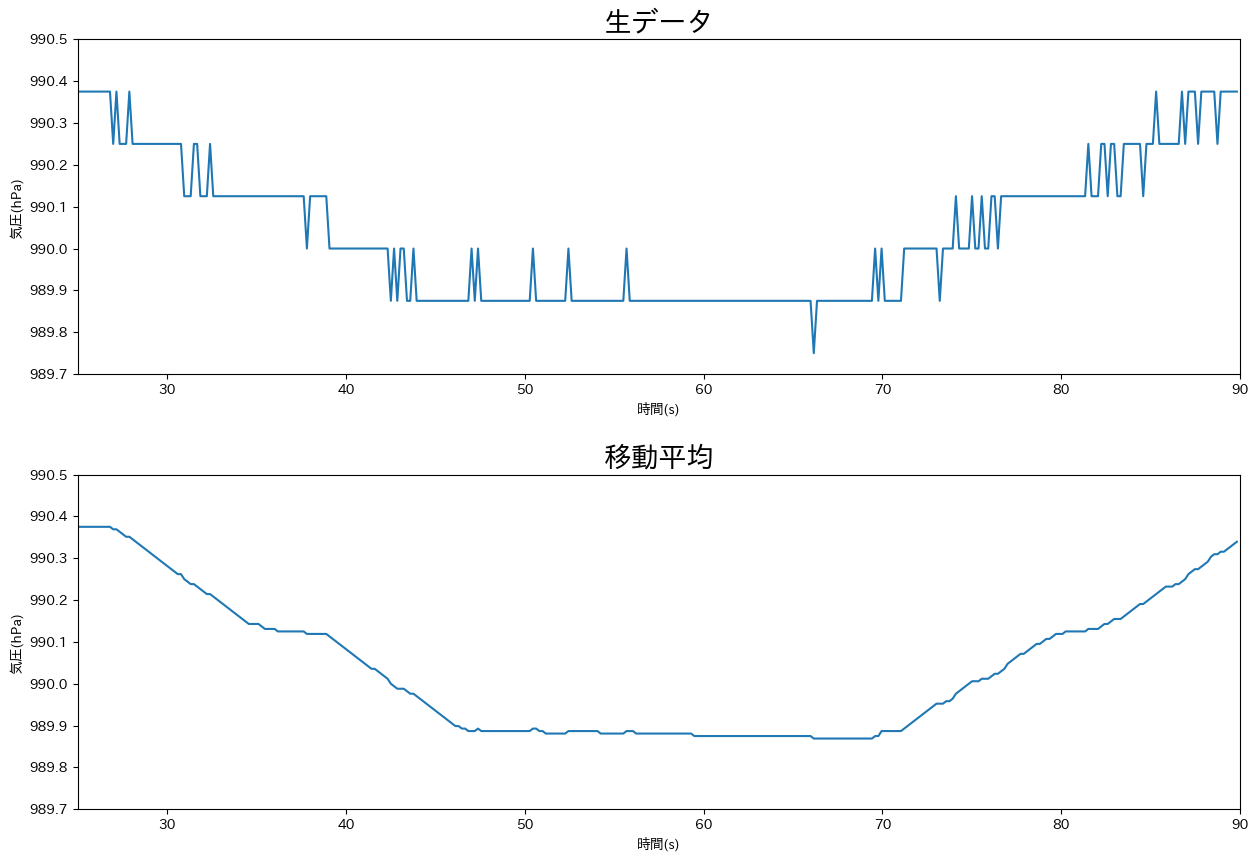

In [5]:
fig = plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.3)
# fig.suptitle('気圧', fontsize=20)

ax1 = plt.subplot(2, 1, 1)
ax1.set_title('生データ', fontsize=20)
ax1.plot(df_pre['t'], df_pre['p'])
ax1.set_xlim(25,90)
ax1.set_ylim(989.7,990.5)
ax1.set_xlabel('時間(s)')
ax1.set_ylabel('気圧(hPa)')

ax2 = plt.subplot(2, 1, 2)
ax2.set_title('移動平均', fontsize=20)
ax2.plot(df_pre['t'], df_pre['low'])
ax2.set_xlim(25,90)
ax2.set_ylim(989.7,990.5)
ax2.set_xlabel('時間(s)')
ax2.set_ylabel('気圧(hPa)')
plt.show()

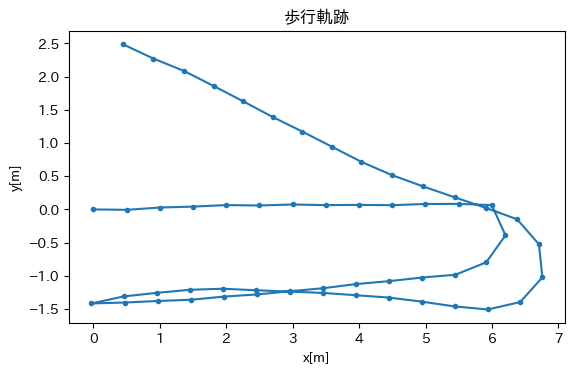

In [6]:
# 軌跡を描く
point = [[0, 0]]
for p in peek:
    x = 0.5 * np.cos(df_gyro['angle_x'][p]) + point[-1][0]
    y = 0.5 * np.sin(df_gyro['angle_x'][p]) + point[-1][1]

    point.append([x, y])

point = pd.DataFrame(data=point, columns=['x', 'y'])

point['x'] = point['x'] - point['x'][0]
point['y'] = point['y'] - point['y'][0]


size = ((-0.5, 7), (-2, 0.5))

plt.plot(point['x'], point['y'], '.-', label='推定', zorder=1)


# 軸を揃える
plt.gca().set_aspect('equal', adjustable='box')

plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5, zorder=2)
plt.title('歩行軌跡')
plt.xlabel('x[m]')
plt.ylabel('y[m]')

plt.grid()
plt.show()

# plt.figure()
# plt.plot(point['x'], point['y'], '.-', label='推定', zorder=1, marker='o')

# # X軸とY軸の範囲を揃える

# #軸を揃える
# plt.xlabel('X 方向 (cm)')
# plt.ylabel('Y 方向 (cm)')
# plt.title('歩行推定')



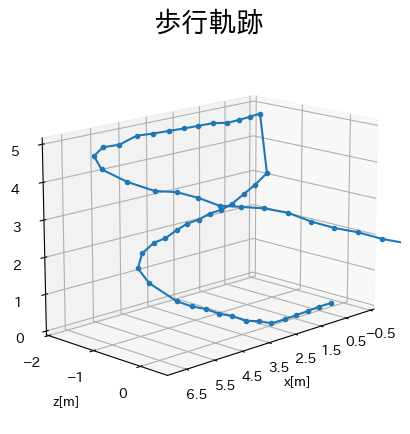

In [7]:
# 軌跡を描く
point = [[0, 0, 0]]
for p in peek:
    x = 0.5 * np.cos(df_gyro['angle_x'][p]) + point[-1][0]
    y = 0.5 * np.sin(df_gyro['angle_x'][p]) + point[-1][1]
    z = df_pre['low'][int(p * 0.0487804878)]
    z = df_pre['low'].max() if np.isnan(z) else z

    point.append([x, y, z])

point = pd.DataFrame(data=point, columns=['x', 'y', 'z'])

point['z'] = (point['z'] - point['z'][1]) * -10
point['z'][0] = point['z'][1]


# グラフを描画する
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')

ax.plot(point['x'], point['y'], point['z'], '.-', zorder=1)

plt.gca().set_aspect('equal', adjustable='box')
plt.title('歩行軌跡', fontsize=20)
plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.ylabel('z[m]')
plt.xticks(np.arange(size[0][0], size[0][1], 1))
plt.yticks(np.arange(size[1][0], size[1][1], 1))
plt.xlim(size[0][0], size[0][1])
plt.ylim(size[1][0], size[1][1])

# 視野の調整
ax.view_init(azim=45,elev=15)

plt.show()


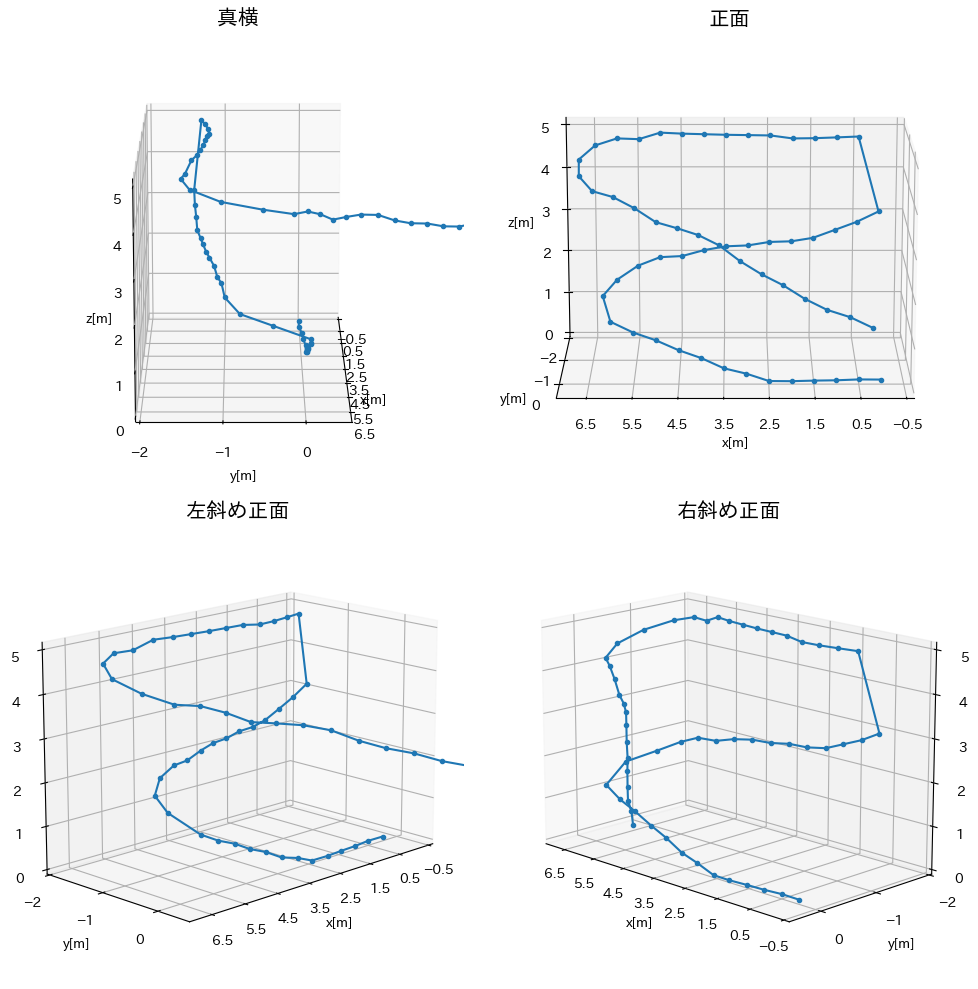

In [8]:
# 軌跡を描く
point = [[0, 0, 0]]
for p in peek:
    x = 0.5 * np.cos(df_gyro['angle_x'][p]) + point[-1][0]
    y = 0.5 * np.sin(df_gyro['angle_x'][p]) + point[-1][1]
    z = df_pre['low'][int(p * 0.0487804878)]
    z = df_pre['low'].max() if np.isnan(z) else z

    point.append([x, y, z])

point = pd.DataFrame(data=point, columns=['x', 'y', 'z'])

point['z'] = (point['z'] - point['z'][1]) * -10
point['z'][0] = point['z'][1]

fig = plt.figure(figsize=(10, 10))

for i in range(4):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.plot(point['x'], point['y'], point['z'], '.-', zorder=1)

    ax.set_aspect('equal', adjustable='box')

    if i == 1:
        i = 2
    elif i == 2:
        i = 1

    if i == 0:
        ax.set_title('真横', fontsize=15)
    elif i == 1:
        ax.set_title('左斜め正面', fontsize=15)
    elif i == 2:
        ax.set_title('正面', fontsize=15)
    elif i == 3:
        ax.set_title('右斜め正面', fontsize=15)
    ax.set_xlabel('x[m]')
    ax.set_ylabel('y[m]')
    ax.set_zlabel('z[m]')
    ax.set_xticks(np.arange(size[0][0], size[0][1], 1))
    ax.set_yticks(np.arange(size[1][0], size[1][1], 1))
    ax.set_xlim(size[0][0], size[0][1])
    ax.set_ylim(size[1][0], size[1][1])

    # 視野の調整
    ax.view_init(azim=0 + i * 45, elev=15)

plt.tight_layout()
plt.show()


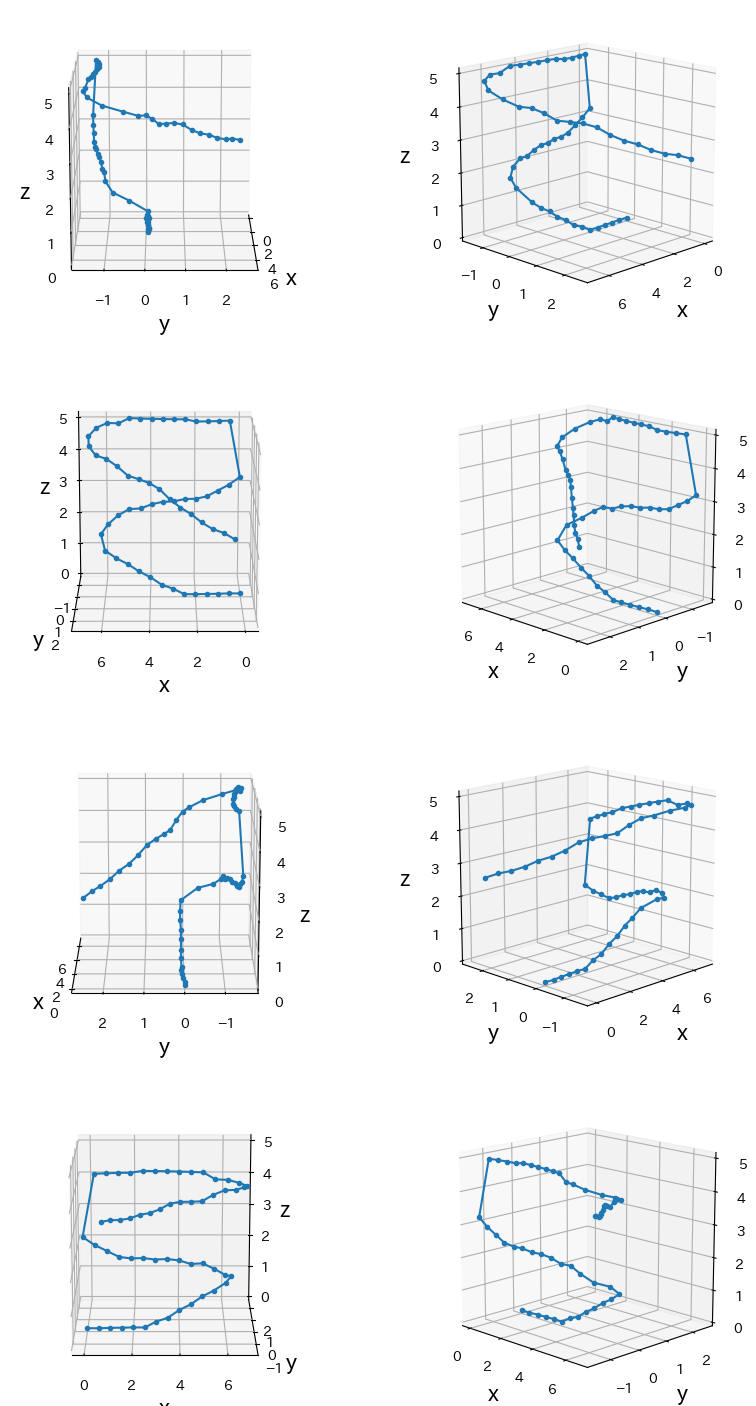

In [9]:
# 軌跡を描く
point = [[0, 0, 0]]
for p in peek:
    x = 0.5 * np.cos(df_gyro['angle_x'][p]) + point[-1][0]
    y = 0.5 * np.sin(df_gyro['angle_x'][p]) + point[-1][1]
    z = df_pre['low'][int(p * 0.0487804878)]
    z = df_pre['low'].max() if np.isnan(z) else z

    point.append([x, y, z])

point = pd.DataFrame(data=point, columns=['x', 'y', 'z'])

point['z'] = (point['z'] - point['z'][1]) * -10
point['z'][0] = point['z'][1]


# 8個のAxes3Dを2列に並べる
fig, ax = plt.subplots(4, 2, figsize=(10,18), subplot_kw=dict(projection='3d'))

ct = 0
# 仰角を30°に固定し、方位角を0°から45°刻みに変化させながらプロットエリアを表示
for k in ax.ravel():
    # 横軸と縦軸の間隔を合わせる
    k.set_box_aspect((1, 1, 1))
    k.view_init(azim=ct*45, elev=15)
    k.plot(point['x'], point['y'], point['z'], '.-', zorder=1)
    k.set_xlabel("x", size=16)
    k.set_ylabel("y", size=16)
    k.set_zlabel("z", size=16)
    ct += 1

plt.show()


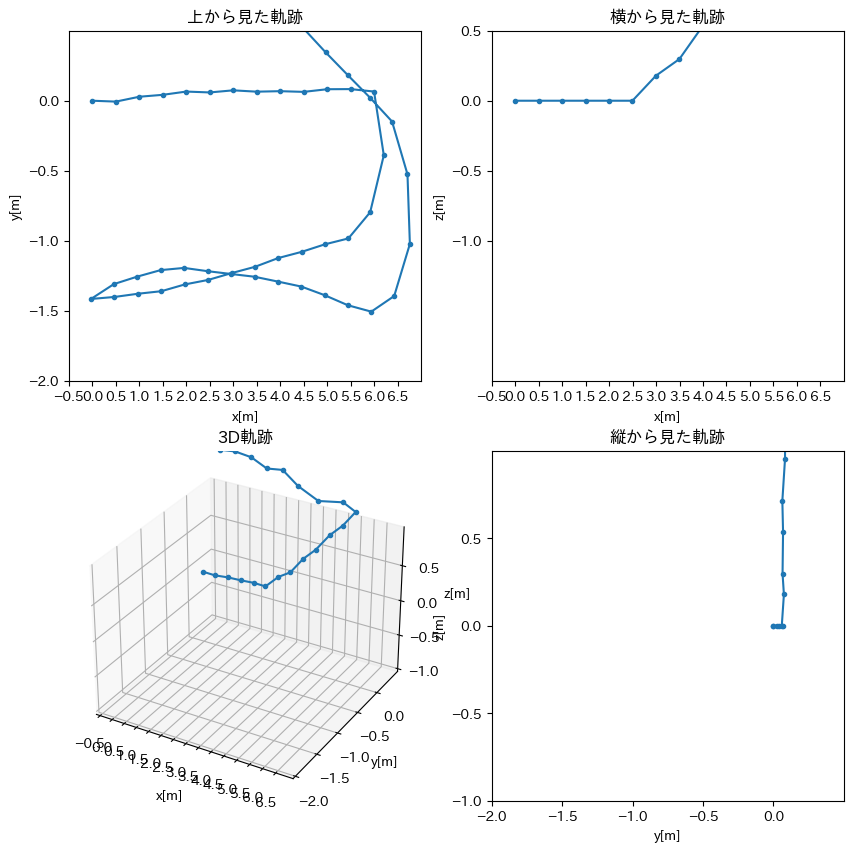

In [10]:

# 軌跡を描く
point = [[0, 0, 0]]
for p in peek:
    x = 0.5 * np.cos(df_gyro['angle_x'][p]) + point[-1][0]
    y = 0.5 * np.sin(df_gyro['angle_x'][p]) + point[-1][1]
    z = df_pre['low'][int(p * 0.0487804878)]
    z = df_pre['low'].max() if np.isnan(z) else z

    point.append([x, y, z])

point = pd.DataFrame(data=point, columns=['x', 'y', 'z'])

point['z'] = (point['z'] - point['z'][1]) * -10
point['z'][0] = point['z'][1]

# 4方向から見た軌跡を描画する
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223, projection='3d')
ax4 = fig.add_subplot(224)

ax1.plot(point['x'], point['y'], '.-', zorder=1)
ax1.set_title('上から見た軌跡')
ax1.set_xlabel('x[m]')
ax1.set_ylabel('y[m]')
ax1.set_xticks(np.arange(size[0][0], size[0][1], 0.5))
ax1.set_yticks(np.arange(size[1][0], size[1][1], 0.5))
ax1.set_xlim(size[0][0], size[0][1])
ax1.set_ylim(size[1][0], size[1][1])

ax2.plot(point['x'], point['z'], '.-', zorder=1)
ax2.set_title('横から見た軌跡')
ax2.set_xlabel('x[m]')
ax2.set_ylabel('z[m]')
ax2.set_xticks(np.arange(size[0][0], size[0][1], 0.5))
ax2.set_yticks(np.arange(-1, 1, 0.5))
ax2.set_xlim(size[0][0], size[0][1])
ax2.set_ylim(size[1][0], size[1][1])

ax3.plot(point['x'], point['y'], point['z'], '.-', zorder=1)
ax3.set_title('3D軌跡')
ax3.set_xlabel('x[m]')
ax3.set_ylabel('y[m]')
ax3.set_zlabel('z[m]')
ax3.set_xticks(np.arange(size[0][0], size[0][1], 0.5))
ax3.set_yticks(np.arange(size[1][0], size[1][1], 0.5))
ax3.set_zticks(np.arange(-1, 1, 0.5))
ax3.set_xlim(size[0][0], size[0][1])
ax3.set_ylim(size[1][0], size[1][1])
ax3.set_zlim(-1, 1)

ax4.plot(point['y'], point['z'], '.-', zorder=1)
ax4.set_title('縦から見た軌跡')
ax4.set_xlabel('y[m]')
ax4.set_ylabel('z[m]')
ax4.set_xticks(np.arange(size[1][0], size[1][1], 0.5))
ax4.set_yticks(np.arange(-1, 1, 0.5))
ax4.set_xlim(size[1][0], size[1][1])
ax4.set_ylim(-1, 1)

plt.show()
